Download data: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

The goal is: to predict Airbnb rental prices

In [109]:
#!pip install --upgrade dtale #downloading dtale

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import dtale

In [111]:
#import dtale.app as dtale_app

#dtale_app.USE_COLAB = True
#dtale.show(data, ignore_duplicate=True)

In [112]:
data = pd.read_csv(r'/content/AB_NYC_2019.csv')
print(data.head(10))

     id  ... availability_365
0  2539  ...              365
1  2595  ...              355
2  3647  ...              365
3  3831  ...              194
4  5022  ...                0
5  5099  ...              129
6  5121  ...                0
7  5178  ...              220
8  5203  ...                0
9  5238  ...              188

[10 rows x 16 columns]


In [113]:
print(data.columns)

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')


In [114]:
print(data.shape)

(48895, 16)


Observation:

There are 16 columns and 49K data-points.

In [115]:
data.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

Observation:

Some columns contains text so maybe there would be need to use BoW, tfidf, w2vec, etc.

In [116]:
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Observation:

There are 4 columns that have null values, have to replace them as it might affect later while considering remaining values of the same column.

In [117]:
data.fillna({'reviews_per_month':0}, inplace=True) #filling null values of 4 columns with respective values
data.fillna({'name':"NoName"}, inplace=True)
data.fillna({'host_name':"NoName"}, inplace=True)
data.fillna({'last_review':"NotReviewed"}, inplace=True)

In [118]:
data.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [119]:
data['price'].head(10)

0    149
1    225
2    150
3     89
4     80
5    200
6     60
7     79
8     79
9    150
Name: price, dtype: int64

In [120]:
data['price'].describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

Observation:

It's a Regression problem. 

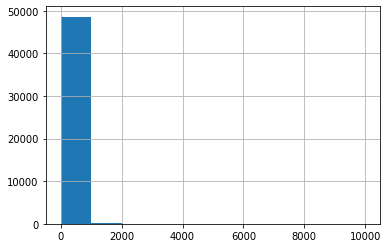

In [121]:
hist_price = data["price"].hist()

Observation:

Most of prices are less than 1000.

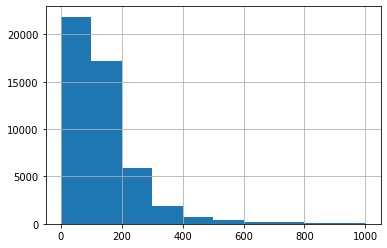

In [122]:
hist_price = data["price"][data['price'] <= 1000].hist()

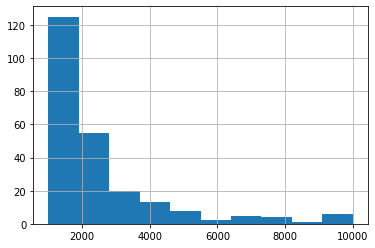

In [123]:
hist_price = data["price"][data['price'] > 1000].hist()

In [124]:
price_greater_than_2000 = data[data['price'] > 1000].value_counts()
print(price_greater_than_2000)

id        name                                                host_id    host_name     neighbourhood_group  neighbourhood       latitude  longitude  room_type        price  minimum_nights  number_of_reviews  last_review  reviews_per_month  calculated_host_listings_count  availability_365
36311055  Stunning & Stylish Brooklyn Luxury, near Train      245712163  Urvashi       Brooklyn             Bedford-Stuyvesant  40.68245  -73.93417  Entire home/apt  1749   1               0                  NotReviewed  0.00               1                               303                 1
10901255  6 BEDROOM W VILLAGE TOWNHOUSE, NYC                  605463     West Village  Manhattan            West Village        40.73303  -74.00500  Entire home/apt  1100   6               4                  2019-05-24   0.12               4                               313                 1
13882394  VIP Duplex Townhouse with Private Garden!!!         49186997   Joseph        Manhattan            Greenwich Villa

Observation:

- In all, there are 239 data-points with rental price > 1000.
- These are either super lavish listings or there can an error during input. Nonetheless, since this records are skewing our data, we can treat them as outliers and drop them.

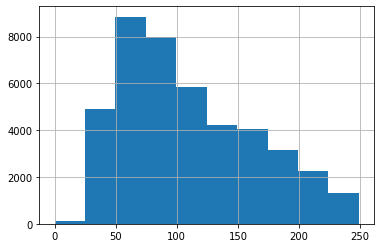

In [125]:
data["price"][data["price"]<250].hist()

In [126]:
data["price"][data["price"]<250].describe()

count    42669.000000
mean       107.897748
std         53.803457
min          0.000000
25%         65.000000
50%         99.000000
75%        150.000000
max        249.000000
Name: price, dtype: float64

Observation:

This is kind of Guassian distribution for rental values < 250.

In [127]:
data['neighbourhood'].value_counts()

Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
                      ... 
New Dorp                 1
Fort Wadsworth           1
Willowbrook              1
Richmondtown             1
Rossville                1
Name: neighbourhood, Length: 221, dtype: int64

In [128]:
neigh =data.groupby("neighbourhood").filter(lambda x: x['neighbourhood'].count() > 200)
print(len(neigh['neighbourhood']))

42276


Observation:

Almost 90% of the data is covered.

In [129]:
neigh1 = data.groupby("neighbourhood").filter(lambda x: x['neighbourhood'].count() == 1)
print(len(neigh1["neighbourhood"]))

6


In [130]:
data['neighbourhood_group'].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

Observation:

There are 5 groups & 85% is covered by Manhattan & Brooklyn. 

In [131]:
ng_price = data.groupby("neighbourhood_group")["price"].mean()
print(ng_price)
data1 = data

neighbourhood_group
Bronx             87.496792
Brooklyn         124.383207
Manhattan        196.875814
Queens            99.517649
Staten Island    114.812332
Name: price, dtype: float64


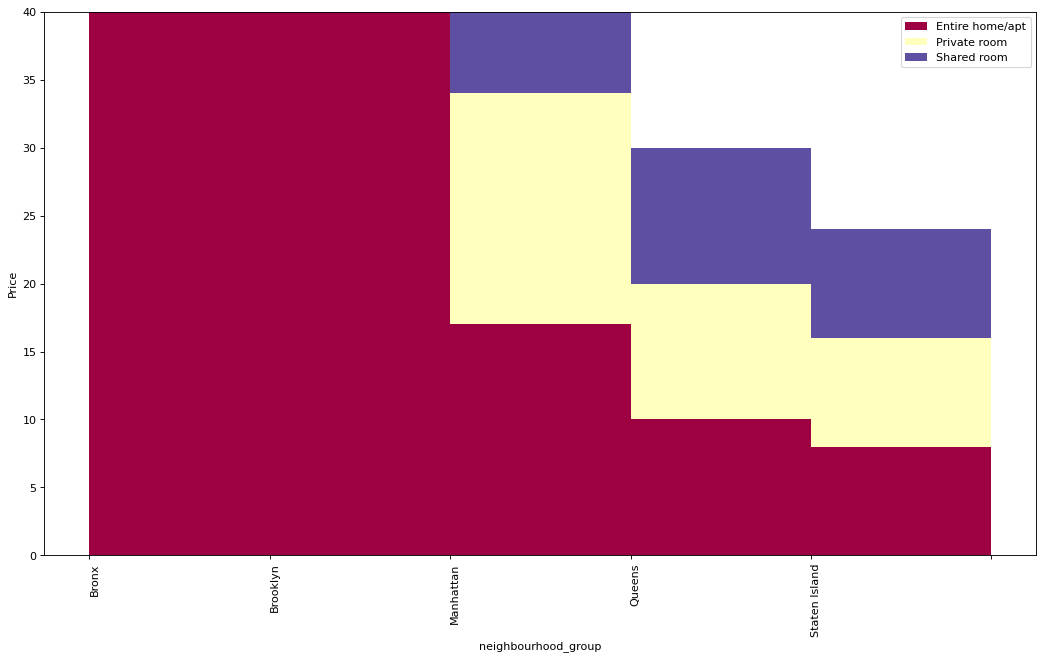

In [139]:

#sns.catplot(x = "neighbourhood_group", y = "price", hue = "room_type", kind = "swarm", data = data1)
#https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/#21.-Histogram-for-Categorical-Variable


x_var = 'neighbourhood_group'
groupby_var = 'room_type'

df_agg = data.loc[:, [x_var, groupby_var]].groupby(groupby_var)
#vals = [df[x_var].values.tolist() for i, df in df_agg]
vals = [data['price'].values.tolist() for i in df_agg]

plt.figure(figsize=(16,9), dpi= 80)
colors = [plt.cm.Spectral(i / float(len(vals) - 1 )) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, data[x_var].unique().__len__(), stacked = True, density = False, color = colors[:len(vals)])

plt.legend({group:col for group, col in zip(np.unique(data[groupby_var]).tolist(), colors[:len(vals)])})
#plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Price")
plt.ylim(0, 40)
plt.xticks(ticks = bins, labels = np.unique(data[x_var]).tolist(), rotation = 90, horizontalalignment = 'left')
plt.show()

Here we can note that Brooklyn and Manhattan tend to have more listings with price > 150. Also, most listings above price > 100 are entire home type followed by private room and shared room which is the cheapest.

In [ ]:
data = data.drop(columns = ["id","host_name"])

id and host_name or host_id are not useful for prediction of rental_price, so dropping them.

In [ ]:
data["name_length"] = data['name'].map(str).apply(len)

In [ ]:
# Max and Min name length
print(data["name_length"].max())
print(data["name_length"].min())
print(data["name_length"].idxmax())
print(data["name_length"].idxmin())

In [ ]:
data.at[25832, 'name']

In [ ]:
data.at[4033, 'name']

In [ ]:
data.plot.scatter(x = "name_length", y = "number_of_reviews" )

In [ ]:
data["number_of_reviews"].corr(data["name_length"])

Here, review can be either positive or negative. Also, there is hardly any relationship here.

In [ ]:
data[data["name_length"] < 50].plot.scatter(x = "price", y = "name_length")

In [ ]:
data["name_length"].corr(data["price"])

In [ ]:
data.name_length.hist()

In [ ]:
data['room_type'].value_counts()

Mostly, room type is either entire home or private room.

In [ ]:
rt_price = data.groupby("room_type")["price"].mean()
print(rt_price)

In [ ]:
data["minimum_nights"].describe()

It's quite weird, range is between 1 night to 1250 nights.

In [ ]:
data["minimum_nights"].hist()

Most of the number of nights are under 100.

In [ ]:
data["minimum_nights"][data["minimum_nights"] < 10].hist()

In [ ]:
data['price'].corr(data['minimum_nights'])

In [ ]:
data["minimum_nights"][data["minimum_nights"] > 30]

Only 747 datapoints have number of minmumn_nights > 30, so replacing all of those with 30.

In [ ]:
data.loc[(data.minimum_nights > 30), "minimum_nights"] = 30

In [ ]:
data['price'].corr(data['minimum_nights'])

In [ ]:
data["availability_365"].describe()

In [ ]:
data["availability_365"].hist()

After analysis, deciding to drop these columns as they will not be useful in prediction


In [ ]:
data.drop(["name", 'last_review', "latitude", 'longitude', 'host_id'], axis = 1, inplace = True)

In [ ]:
corr = data.corr(method = 'pearson')
plt.figure(figsize = (15,8))
sns.heatmap(corr, annot = True)
data.columns